In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import igraph
import seaborn as sns
###import packages
from scEasyMode import mousefilter
from scEasyMode import clusterplot
from scEasyMode import pymulti
from scEasyMode import sceasy

## read in data

In [2]:
###readin
osi= sceasy.read('osi_only.preprocessed')

In [3]:
### change things over into continuous time
sample_dict = {
    '0T':0.0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
    'DMSO_T1_30m':0.5,
    'DMSO_T2_2H':2,
    'DMSO_T3_8H':8,
    'DMSO_T4_24H':24,
    'DMSO_T4_48H':48
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 
osi.obs['group'] = osi.obs.apply(lambda row: str(row['sample'])[:3],axis=1) 
###subset
osi= osi[osi.obs['group']!='DMS']

## visualize the yap gene set over time

In [4]:
def violin_geneset(adata,labels,genelist,genes):
    ####format marker genes
    marker_genes = dict()
    marker_genes[genelist] = genes
    ####Check expression of markers
    ids = np.in1d(adata.var_names, marker_genes[genelist])
    #Calculate the mean expression of markers
    adata.obs[genelist] = adata.X[:,ids].mean(1)
    #Plot geneset expression
    for label in labels:
        sc.pl.violin(adata, genelist, groupby=label)
        sc.pl.draw_graph(adata, color=genelist)

In [5]:
####readin YAP geneset
osi.obs['hours'] = osi.obs['time'].astype(str)
genelist = 'YAP'
yapfile = open('genesets/YAP_up.txt', 'r')
YAP = yapfile.read().split('\n')
YAP = list(set(YAP).intersection(set(osi.var_names)))
yapfile.close()

Trying to set attribute `.obs` of view, making a copy.


## need to break it down more granularly

In [112]:
YAP_matrix = osi.var[osi.var.index.isin(YAP)]

In [113]:
tmp_osi = osi[:,osi.var.index.isin(YAP)]

In [114]:
### get metacells, zscore (for plotting) and expr for downstream analysis
metacells = sceasy.metacell_bylabel(tmp_osi,label='hours',zscore=True).transpose()
metacells_expr = sceasy.metacell_bylabel(tmp_osi,label='hours',zscore=False).transpose()
### format
metacells = metacells[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]
metacells_expr = metacells_expr[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]

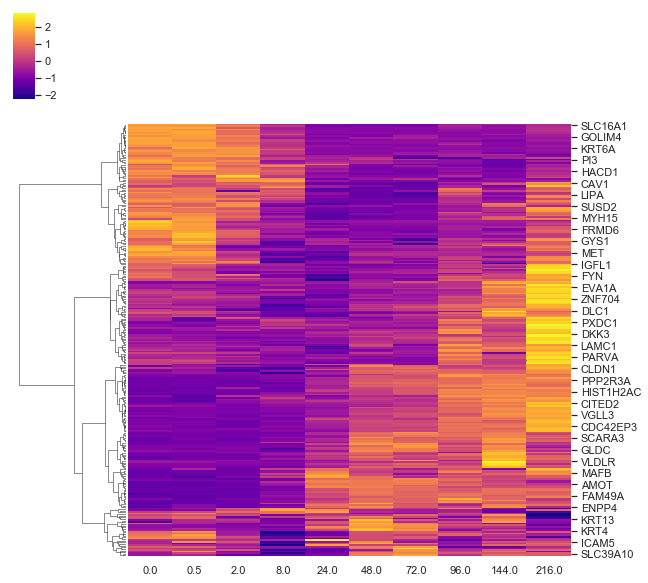

In [115]:
### plot the zscore normalized matrix to find changes and clusters of subgroups over time
sns.set(rc={'figure.figsize':(10,10)})
sns.clustermap(metacells,cmap='plasma',col_cluster=False,method='ward',metric='cityblock')

In [116]:
import scipy.cluster.hierarchy as sch
####
numclusts = 4
rngclusts = range(1,numclusts+1)
####
df = metacells
df_expr = metacells_expr
# retrieve clusters using fcluster 
d = sch.distance.pdist(df,metric='cityblock')
L = sch.linkage(d, method='ward')
# numclusts can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, t=numclusts, criterion='maxclust')
# clusters indicices correspond to incides of original df
clustering = []
# subset clusters
sets = []
sets_sc = []
###
for i,cluster in enumerate(clusters):
    clustering.append([df.index[i], cluster])
###
clustering = pd.DataFrame(clustering)
clustering.columns = ['gene','cluster']
clustering.set_index('gene',inplace=True)
### convert to dict
clustering_dict = clustering.to_dict()['cluster']
### add to df
df['cluster'] = df.apply(lambda row: clustering_dict[row.name],axis=1)
df_expr['cluster'] = df_expr.apply(lambda row: clustering_dict[row.name],axis=1)
### save 
df.to_csv('figures/clustering_zscore.csv')
df_expr.to_csv('figures/clustering_expr.csv')

1
4
3
2


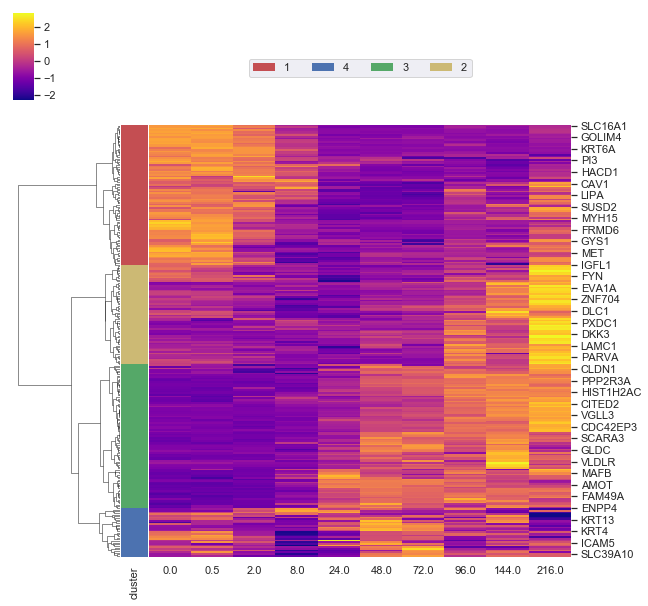

In [133]:
### plot the zscore normalized matrix to find changes and clusters of subgroups over time
sns.set(rc={'figure.figsize':(10,10)})
## colors
lut = dict(zip(df.cluster.unique(), "rbgy"))
row_colors = df.cluster.map(lut)
## plot
g = sns.clustermap(df.drop(['cluster'],axis=1),cmap='plasma',col_cluster=False,method='ward',metric='cityblock',row_colors=row_colors)
# Draw the legend bar for the classes                 
for label in df.cluster.unique():
    print(label)
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
### save
plt.savefig('figures/YAP_subset.pdf')

In [134]:
#### gene expression over time by cluster; expr values
expr_mean_clust = df_expr.copy()
expr_mean_clust = expr_mean_clust.set_index('cluster')
## normalize to T0 
expr_mean_clust = expr_mean_clust.div(expr_mean_clust['0.0'],axis=0)
expr_mean_clust
## stack
expr_mean_clust = pd.DataFrame(expr_mean_clust.stack()).reset_index()
expr_mean_clust.columns = ['cluster','timepoint','expr']
expr_mean_clust['timepoint'] = expr_mean_clust['timepoint'].astype(np.float)

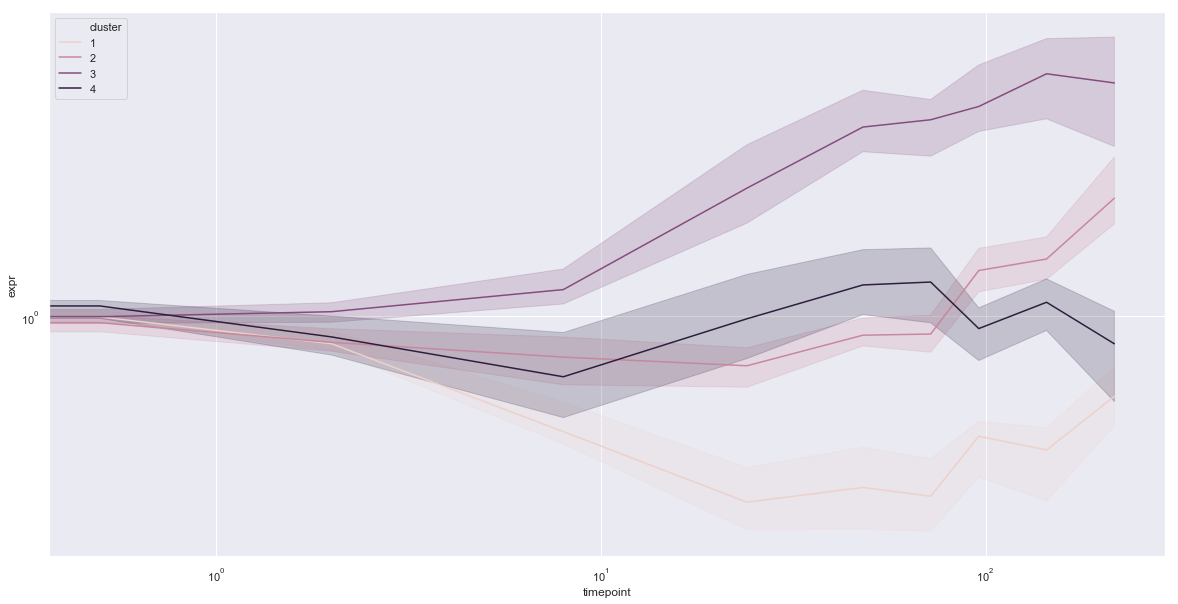

In [145]:
sns.set(rc={'figure.figsize':(20,10)})
#### plot
grid = sns.lineplot(data=expr_mean_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
grid.set(xscale="log",yscale='log')
### save
plt.savefig('figures/YAP_subset_bytime.pdf')

## Clearly these 4 gene groups show differing expression patterns

#### it appears that cluster 3 is an early resistance program
#### clusters 2 and 1 appear to be late resistance programs, that decrease initially
#### cluster 4 appears to be relatively unchanged throughout, hovering around 1

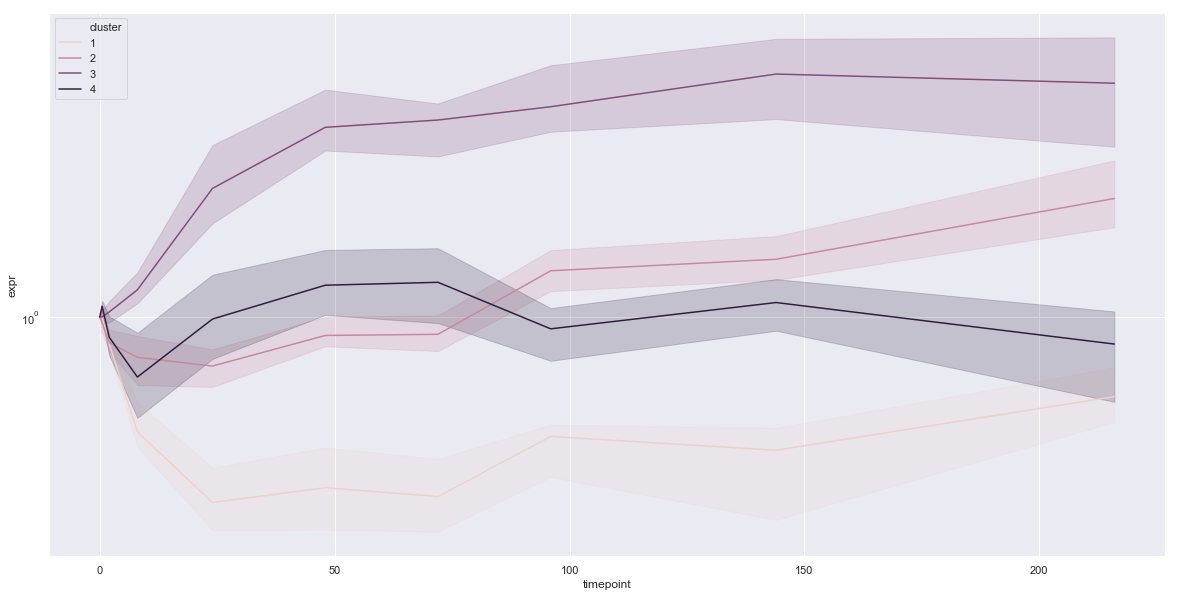

In [146]:
sns.set(rc={'figure.figsize':(20,10)})
#### plot
grid = sns.lineplot(data=expr_mean_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
grid.set(yscale='log')
### save
plt.savefig('figures/YAP_subset_bytime.linear.pdf')

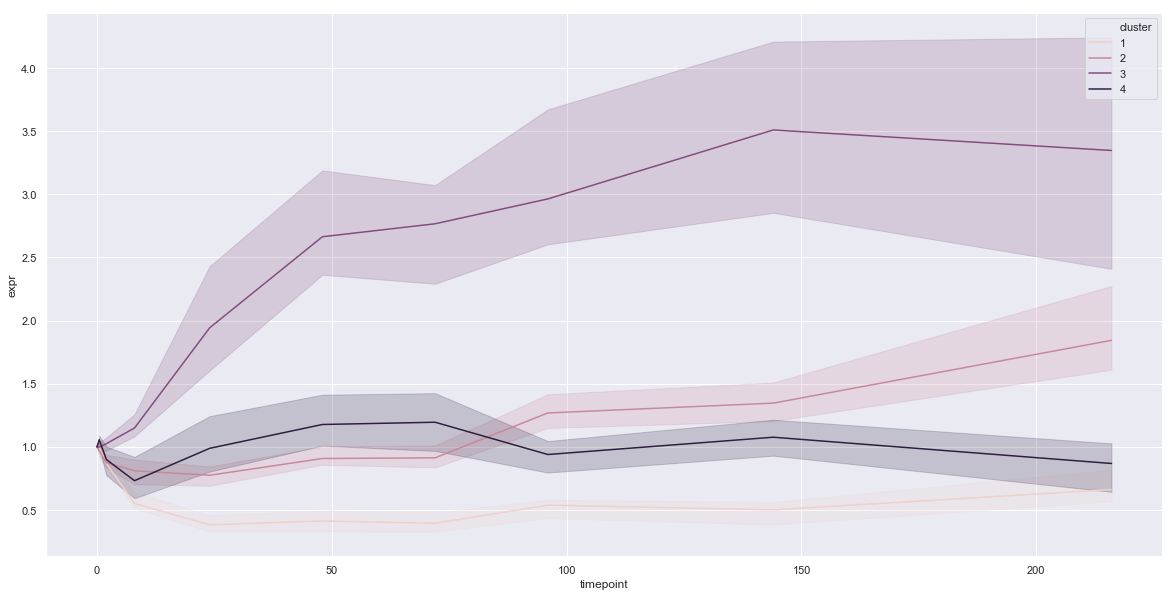

In [148]:
sns.set(rc={'figure.figsize':(20,10)})
#### plot
grid = sns.lineplot(data=expr_mean_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
### save
plt.savefig('figures/YAP_subset_bytime.linear.linear.pdf')

## okay well lets see if this effect is due to osimertinib or drift

In [158]:
###readin
merged = sceasy.read('merged_0')

In [159]:
###define
cutoff = 0.3
##label
merged = sceasy.annotate_mito(merged,cutoff)

In [160]:
###split
merged.obs['group'] = merged.obs['sample'].str[:3]
treatment = merged[merged.obs['group']!='DMS']
vehicle = merged[merged.obs['group']!='OSI']

In [170]:
### change things over into continuous time
sample_dict = {
    '0T':0.0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
    'DMSO_T1_30m':0.5,
    'DMSO_T2_2H':2,
    'DMSO_T3_8H':8,
    'DMSO_T4_24H':24,
    'DMSO_T4_48H':48
}
###
vehicle.obs['time'] = vehicle.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 
vehicle.obs['group'] = vehicle.obs.apply(lambda row: str(row['sample'])[:3],axis=1) 
vehicle.obs['hours'] = vehicle.obs['time'].astype(str)



### format the vehicle data so we can compare it

In [176]:
tmp_vehicle = vehicle[:,vehicle.var.index.isin(YAP)]
### get metacells, zscore (for plotting) and expr for downstream analysis
metacells = sceasy.metacell_bylabel(tmp_vehicle,label='hours',zscore=True).transpose()
metacells_expr = sceasy.metacell_bylabel(tmp_vehicle,label='hours',zscore=False).transpose()
### format
metacells = metacells[['0.0','0.5','2.0','8.0','24.0','48.0']]
metacells_expr = metacells_expr[['0.0','0.5','2.0','8.0','24.0','48.0']]
##
metacells['cluster'] = metacells.apply(lambda row: clustering_dict[row.name],axis=1)
metacells_expr['cluster'] = metacells_expr.apply(lambda row: clustering_dict[row.name],axis=1)



In [178]:
#### gene expression over time by cluster; expr values
vehicle_clust = metacells_expr.copy()
vehicle_clust = vehicle_clust.set_index('cluster')
## normalize to T0 
vehicle_clust = vehicle_clust.div(vehicle_clust['0.0'],axis=0)
vehicle_clust
## stack
vehicle_clust = pd.DataFrame(vehicle_clust.stack()).reset_index()
vehicle_clust.columns = ['cluster','timepoint','expr']
vehicle_clust['timepoint'] = vehicle_clust['timepoint'].astype(np.float)

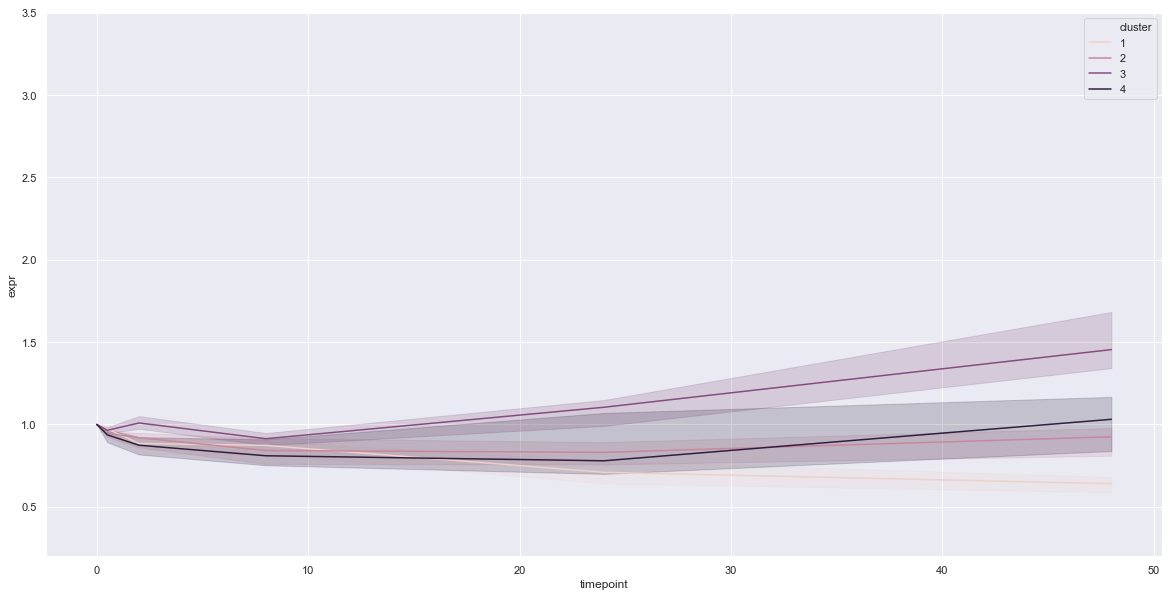

In [195]:
sns.set(rc={'figure.figsize':(20,10)})
#### plot
grid = sns.lineplot(data=vehicle_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
grid.set(ylim=(0.2, 3.5))
### save
plt.savefig('figures/YAP_subset_bytime.linear.linear.VEHICLE.pdf')

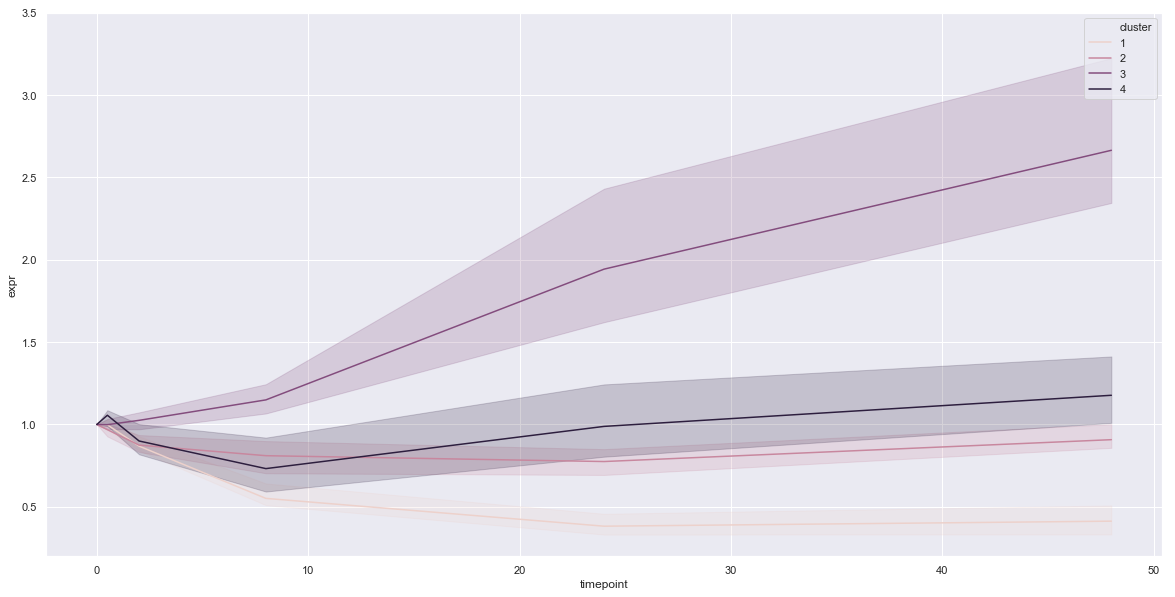

In [196]:
sns.set(rc={'figure.figsize':(20,10)})
#### plot
osi_clust = expr_mean_clust[expr_mean_clust['timepoint'] <= 48.0]
grid = sns.lineplot(data=osi_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
grid.set(ylim=(0.2, 3.5))
### save
plt.savefig('figures/YAP_subset_bytime.linear.linear.OSIearly.pdf')

In [150]:
### change things over into continuous time
sample_dict = {
    '0T':0.0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
    'DMSO_T1_30m':0.5,
    'DMSO_T2_2H':2,
    'DMSO_T3_8H':8,
    'DMSO_T4_24H':24,
    'DMSO_T4_48H':48
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 
osi.obs['group'] = osi.obs.apply(lambda row: str(row['sample'])[:3],axis=1) 
# ###subset
# osi= osi[osi.obs['group']!='DMS']

In [153]:
set(osi.obs.group.tolist())

{'0T', 'OSI'}

In [ ]:
# tmp_osi = pd.DataFrame(index=tmp_osi.obs.index.tolist(),columns=tmp_osi.var.index.tolist(),data=tmp_osi.X)
# tmp_osi['hours'] = osi.obs.hours
# tmp_osi.sort_values(by='hours',inplace=True)

In [ ]:
# lut = dict(zip(tmp_osi.hours.unique(), "rbg"))
# row_colors = tmp_osi.hours.map(lut)
# sns.clustermap(tmp_osi.drop(['hours'],axis=1),standard_scale=1,row_colors=row_colors,row_cluster=False)

In [ ]:
# sc.pl.dotplot(osi,var_names=YAP,groupby='hours',standard_scale='var')

In [ ]:
# ### visualize which genes may be useful to see
# colors = []
# y_cutoff = 0.0
# x_cutoff = 0.1
# for x,y in zip(YAP_matrix['means'],YAP_matrix['dispersions_norm']):
#     if y > y_cutoff and x > x_cutoff:
#         colors.append('keep')
#     else:
#         colors.append('drop')
# YAP_matrix['colors'] = colors
# ### subset
# YAP_subset = YAP_matrix[YAP_matrix.colors=='keep'].index.tolist()
# ### plot
# sns.scatterplot(data=YAP_matrix,x='means',y='dispersions_norm',hue='colors')

In [ ]:
tmp_osi.drop(['hours'],axis=1)

In [ ]:
clusterplot.plot(osi,covariates=['leiden'],sample='sample',cluster_palette=['Red','Green','Purple','Magenta','Blue','Yellow','Teal','Black'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('figures/treatment_time_clusters.pdf')

## Define stable states

In [ ]:
statedict = {
    9:1,
    8:1,
    7:1,
    6:1,
    5:1,
    2:1,
    10:2,
    11:2,
    0:3,
    0:3,
    1:4,
    3:4,
    4:4,
    12:0,
    13:0,
    14:0,
    15:0
}


In [ ]:
osi.obs['state'] = osi.obs.apply(lambda row: str(statedict[int(row['leiden'])]),axis=1)

In [ ]:
osi = osi[osi.obs['state']!=str(0)]

In [ ]:
sc.pl.umap(osi,color='state')

In [ ]:
### change things over into continuous time
sample_dict = {
    '0T':0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 
osi.obs['group'] = osi.obs.apply(lambda row: str(row['sample'])[:3],axis=1) 


# Create metacell and calculate LOGFC for input to iPAGE

In [ ]:
def metacell_bylabel(scobject,label,zscore=True):
    clusters = []
    metacells = []
    ###extract metacells
    for cluster in set(scobject.obs[label]):
        ##get cluster
        clust = scobject[scobject.obs[label]==cluster].X
        ##average to metacell
        clust = clust.mean(axis=0)
        ##append to index
        metacells.append(pd.DataFrame(clust)[0].tolist())
        clusters.append(cluster)
    ###format
    merged = pd.DataFrame(metacells,index=clusters,columns=scobject.var.index.tolist())
    ###zscore
    if zscore == True:
        merged = pd.DataFrame(stats.zscore(merged),index=clusters,columns=scobject.var.index.tolist())
    ###return
    return(merged)      

In [ ]:
merged = metacell_bylabel(osi,label='state',zscore=False)
merged.to_csv('metacell_raw.csv',sep=',')

In [ ]:
merged_tp = merged.copy().transpose()
one_two = np.log2(merged_tp['2']/merged_tp['1'])
two_three = np.log2(merged_tp['3']/merged_tp['2'])
three_four = np.log2(merged_tp['4']/merged_tp['3'])


In [ ]:
plt.figure()
one_two.hist(bins=100)
plt.figure()
two_three.hist(bins=100)
plt.figure()
three_four.hist(bins=100)

In [ ]:
one_two.to_csv('log2FC_1_2.tsv',sep='\t')
two_three.to_csv('log2FC_2_3.tsv',sep='\t')
three_four.to_csv('log2FC_3_4.tsv',sep='\t')